In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
print(tf.__version__)
print(K.__version__)

2.2.0
2.3.0-tf


# VQ_VAE

### Dataset and Hyperparameters

In [2]:
model_dir = "/home/featurize/models/"
dataset_name = 'dida'
var_list = ['u(m/s)', 'v(m/s)', 'h(m)']
ds_min = [0, 0, 0]
ds_max = [1, 1, 1]
if_Train = True

In [3]:
print('find {} in registed datasets: {}'.format(dataset_name, tfds.list_builders().index(dataset_name)))

find dida in registed datasets: 63


In [4]:
INPUT_SHAPE = (180, 360, 3)
VQVAE_BATCH_SIZE = 96
VQVAE_NUM_EPOCHS = 60
VQVAE_LAYERS = [48, 64]
VQVAE_LEARNING_RATE = 1e-3

NUM_LATENT_K = 128
NUM_LATENT_D = 96
BETA = 0.25

In [5]:
field_train, case_train = tfds.as_numpy(tfds.load(
    dataset_name,
    split='train',
    batch_size=-1,
    as_supervised=True,
))
field_test, case_test = tfds.as_numpy(tfds.load(
    dataset_name,
    split='test',
    batch_size=-1,
    as_supervised=True,
))
field = np.concatenate([field_train, field_test])
print(type(field), field.shape)
ds_min = Kb.min(field, axis=[0, 1, 2])
ds_max = Kb.max(field, axis=[0, 1, 2])
print('ds_min:{};\nds_max:{}'.format(ds_min, ds_max))

<class 'numpy.ndarray'> (6400, 180, 360, 3)
ds_min:[ -38.809258  -66.06329  1096.237   ];
ds_max:[  100.91548    66.06329 10582.989  ]


In [6]:
def preprocessor(image):
    # Convert Int to Float and scale from [0, 255] to [0.0, 1.0]
    # image = tf.image.convert_image_dtype(image,
    #                                     dtype=tf.float32)
    # Resize the image to size=[width, height]
    image = (image - ds_min)/(ds_max - ds_min)
    image = tf.image.resize(image,
                            size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
                            method="bilinear",
                            preserve_aspect_ratio=False)
    return image

In [7]:
for item in range(field_train.shape[0]):
    image = field_train[item, :, :, :]
    field_train[item, :, :, :] = preprocessor(image)

In [8]:
# def preprocessor(image, label):
#     # Convert Int to Float and scale from [0, 255] to [0.0, 1.0]
#     # image = tf.image.convert_image_dtype(image,
#     #                                     dtype=tf.float32)
#     # Resize the image to size=[width, height]
#     image = (image - ds_min)/(ds_max - ds_min)
#     image = tf.image.resize(image,
#                             size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
#                             method="bilinear",
#                             preserve_aspect_ratio=False)
#     return image, label

In [9]:
# (ds_train, ds_test), ds_info = tfds.load(
#     dataset_name,
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )
# assert isinstance(ds_train, tf.data.Dataset)
# assert isinstance(ds_test, tf.data.Dataset)

In [10]:
# ds_train = ds_train.map(preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(VQVAE_BATCH_SIZE)
# ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# ds_test = ds_test.map(preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(VQVAE_BATCH_SIZE)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### Vector Quantizer

In [12]:
class VectorQuantizer(K.layers.Layer):
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k

    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)

    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index

    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

In [13]:
def residual_block(x):
    dim = K.int_shape(x)[-1]
    xo = x
    x = Activation('relu')(x)
    x = Conv2D(dim, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(dim, 1, padding='same')(x)
    return Add()([xo, x])

In [14]:
def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=5, padding='SAME', activation='relu', 
                            strides=(3, 3), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e


def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=5, strides=(3, 3), padding="SAME", 
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), 
                                       padding="SAME", activation='relu', name='output')(y)
    return decoded

In [15]:
# def encoder_pass(inputs, d, num_layers=[16, 32]):
#     x = inputs
#     for i, filters in enumerate(num_layers):
#         x = K.layers.Conv2D(filters=filters, kernel_size=5, padding='SAME', activation='relu', 
#                             strides=(3, 3), name="conv{}".format(i + 1))(x)
#     z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
#                           strides=(1, 1), name='z_e')(x)
#     return z_e


# def decoder_pass(inputs, num_layers=[32, 16]):
#     y = inputs
#     for i, filters in enumerate(num_layers):
#         y = K.layers.Conv2DTranspose(filters=filters, kernel_size=5, strides=(3, 3), padding="SAME", 
#                                      activation='relu', name="convT{}".format(i + 1))(y)
#     decoded = K.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), 
#                                        padding="SAME", activation='sigmoid', name='output')(y)
#     return decoded

In [16]:
def build_vqvae(k, d, input_shape=(180, 360, 3), num_layers=[16, 32]):
    # Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZEX = int(z_e.get_shape()[1])
    SIZEY = int(z_e.get_shape()[2])

    # Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    # Decoder
    decoder_inputs = K.layers.Input(shape=(SIZEX, SIZEY, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')

    # VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x: x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')

    # VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZEX, SIZEY), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')

    # Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZEX, SIZEY), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")

    # Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')

    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook

    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook


vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(128, 96) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(128, 96) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 180, 360, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 120, 48)  3648        encoder_inputs[0][0]             
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 20, 40, 64)   76864       conv1[0][0]                      
__________________________________________________________________________________________________
z_e (Conv2D)                    (None, 20, 40, 96)   55392       conv2[0][0]                      
_____________________________________________________________________________________________

In [17]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss


def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss

In [18]:
def zq_norm(y_true, y_pred):
    del y_true
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))


def ze_norm(y_true, y_pred):
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [19]:
# vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer=K.optimizers.Adam(VQVAE_LEARNING_RATE))
# history = vq_vae.fit(field_train, [field_train, np.zeros(field_train.shape)], epochs=VQVAE_NUM_EPOCHS, batch_size=VQVAE_BATCH_SIZE, verbose=2)

In [20]:
# if if_Train is True:
#     vq_vae.save("pixelCNN-vq_vae-trainable")

493


/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:5096: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return npsel.concatenate((a,a[slicer]),axis=axis)
/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


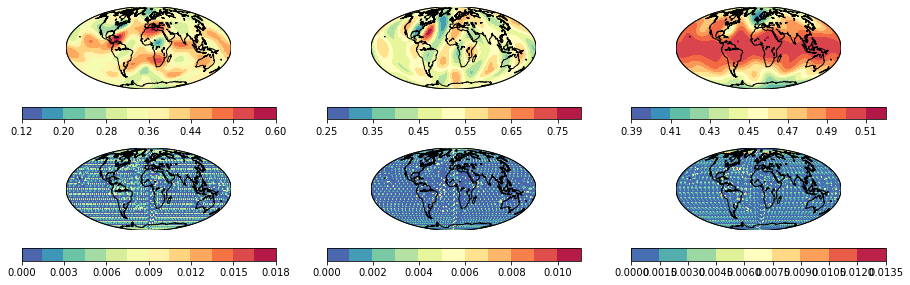

In [21]:
rows = ['gt','rec']
lons = np.arange(0, 360, 360/field.shape[2])
lats = np.arange(-90,90, 181/field.shape[1])
fig, axes = plt.subplots(len(rows), len(var_list), figsize=(12,4))
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)

item = int(np.random.rand()*field_test.shape[0])
# item = 922
print(item)
field_test[item] = (field_test[item] - ds_min)/(ds_max - ds_min)
for n_col, str_row in enumerate(var_list):
    m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
                llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0, ax=axes[0, n_col])
    m.drawcoastlines()
    m.drawmapboundary()
    value_cyclic, lons_cyclic = addcyclic(field_test[item, :, :, n_col], lons)
    value_cyclic, lons_cyclic = shiftgrid(180., value_cyclic, lons_cyclic, start=False)
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
    x, y = m(lon2d, lat2d)
    cs = m.contourf(x, y, value_cyclic, 11, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=1, ax=axes[0, n_col])

rec_field, rec_case = vq_vae.predict(field_test[item:item+1])
for n_col, str_row in enumerate(var_list):
    m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
                llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0, ax=axes[1, n_col])
    m.drawcoastlines()
    m.drawmapboundary()
    value_cyclic, lons_cyclic = addcyclic(rec_field[0, :, :, n_col], lons)
    value_cyclic, lons_cyclic = shiftgrid(180., value_cyclic, lons_cyclic, start=False)
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
    x, y = m(lon2d, lat2d)
    cs = m.contourf(x, y, value_cyclic, 11, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=1, ax=axes[1, n_col])

In [22]:
num_epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history.history["loss"], label="total_loss")
plt.plot(num_epochs, history.history["decoder_loss"], label="recons_loss")
plt.plot(num_epochs, history.history["latent_codes_loss"], label="vq_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

NameError: name 'history' is not defined

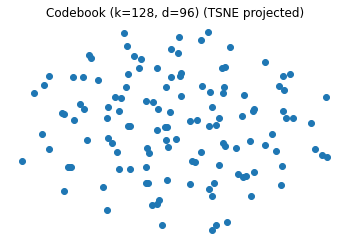

In [23]:
from sklearn.manifold import TSNE
codebook = get_vq_vae_codebook()
codebook = TSNE(2).fit_transform(codebook)
plt.title("Codebook (k={}, d={}) (TSNE projected)".format(NUM_LATENT_K, NUM_LATENT_D))
plt.scatter(codebook[:, 0], codebook[:, 1])
plt.axis('off')
plt.show()

Images generated under a uniform prior (training assumption)


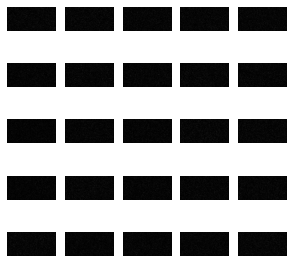

In [24]:
def generate_from_random(sampler, k, sizex, sizey, n_row, n_col):
    n = n_col * n_row
    indices = np.random.randint(0, k, size=(n, sizex, sizey))
    generated = sampler.predict(indices, steps=1)
    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
SIZEX = 20
SIZEY = 40
print("Images generated under a uniform prior (training assumption)")
generate_from_random(vq_vae_sampler, NUM_LATENT_K, SIZEX, SIZEY, 5, 5)

In [25]:
# References:
# https://github.com/anantzoid/Conditional-PixelCNN-decoder/blob/master/layers.py
# https://github.com/ritheshkumar95/pytorch-vqvae

def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return Kb.tanh(x) * Kb.sigmoid(y)


class MaskedConv2D(K.layers.Layer):
    """Masked convolution"""
    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction     # Horizontal or vertical
        self.mode = mode               # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)
    
    def build(self, input_shape):   
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2        
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim,], trainable=True)
    
    def call(self, inputs):
        return K.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b

    
def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block. 
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction, 
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)

    v_stack = K.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)

    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = K.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = K.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = K.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)

    h_stack_out =  K.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out

In [26]:
# Dataset to train the Prior
z_train = encoder.predict(field_train)
z_train.shape

(5440, 20, 40)

In [27]:
field_test, case_test = tfds.as_numpy(tfds.load(
    dataset_name,
    split='test',
    batch_size=-1,
    as_supervised=True,
))
for item in range(field_test.shape[0]):
    image = field_test[item, :, :, :]
    field_test[item, :, :, :] = preprocessor(image)

Images encoded as discrete codes


/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:5096: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return npsel.concatenate((a,a[slicer]),axis=axis)


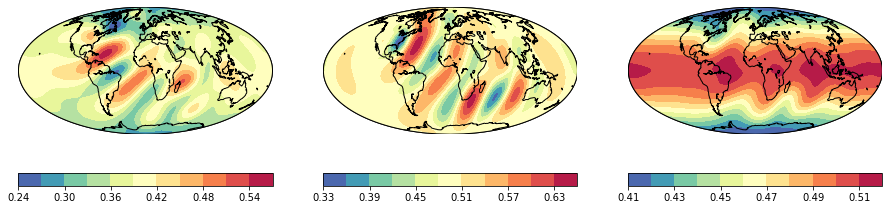

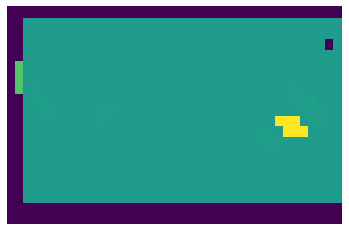

In [28]:
# original versus reconstructions
def viz_codes(encoder, item, n, random=1):
    
    if random == 1:
        x = np.random.choice(field_test.shape[0], size=n, replace=False)
        print(x)
        x = field_test[x]
        codes = encoder.predict(x)
        fig = plt.figure(figsize=(4, 3))
        for i in range(n):
            plt.subplot(3, 4, i+1)
            plt.pcolor(codes[i, ::-1, :])
            plt.axis('off')
        plt.show()
    else:
        fig, axes = plt.subplots(1, len(var_list), figsize=(12,4))
        fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)

        # item = int(np.random.rand()*field_test.shape[0])
        for n_col, str_row in enumerate(var_list):
            m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
                        llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0, ax=axes[n_col])
            m.drawcoastlines()
            m.drawmapboundary()
            value_cyclic, lons_cyclic = addcyclic(field_test[item, :, :, n_col], lons)
            value_cyclic, lons_cyclic = shiftgrid(180., value_cyclic, lons_cyclic, start=False)
            lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
            x, y = m(lon2d, lat2d)
            cs = m.contourf(x, y, value_cyclic, 11, cmap=plt.cm.Spectral_r)
            cbar = plt.colorbar(cs, orientation='horizontal', shrink=1, ax=axes[n_col])

        x = field_test[item:item+1]
        codes = encoder.predict(x)
        fig2 = plt.figure(num='code')
        plt.pcolor(codes[0, ::-1, :])
        plt.axis('off')
        plt.show()


print("Images encoded as discrete codes")
viz_codes(encoder, 32, 12, 0)

In [29]:
PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

In [30]:
def build_pixelcnn(codes_sampler, k, sizex, sizey, num_layers, num_feature_maps=32):
    pixelcnn_prior_inputs = K.layers.Input(shape=(sizex, sizey), name='pixelcnn_prior_inputs', dtype=tf.int32)
    z_q = codes_sampler(pixelcnn_prior_inputs)  # maps indices to the actual codebook

    v_stack_in, h_stack_in = z_q, z_q
    for i in range(num_layers):
        mask = 'b' if i > 0 else 'a'
        kernel_size = 3 if i > 0 else 7
        residual = True if i > 0 else False
        v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, num_feature_maps,
                                                     kernel=kernel_size, residual=residual, i=i + 1)

    fc1 = K.layers.Conv2D(filters=num_feature_maps, kernel_size=1, name="fc1")(h_stack_in)
    fc2 = K.layers.Conv2D(filters=k, kernel_size=1, name="fc2")(fc1) 
    # outputs logits for probabilities of codebook indices for each cell

    pixelcnn_prior = K.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')

    # Distribution to sample from the pixelcnn
    dist = tf.compat.v1.distributions.Categorical(logits=fc2)
    sampled = dist.sample()
    prior_sampler = K.Model(inputs=pixelcnn_prior_inputs, outputs=sampled, name='pixelcnn-prior-sampler')
    return pixelcnn_prior, prior_sampler


pixelcnn_prior, prior_sampler = build_pixelcnn(codes_sampler, NUM_LATENT_K, SIZEX, SIZEY,
                                               PIXELCNN_NUM_BLOCKS, PIXELCNN_NUM_FEATURE_MAPS)
pixelcnn_prior.summary()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
Use `tf.random.categorical` instead.


Instructions for updating:
Use `tf.random.categorical` instead.


Model: "pixelcnn-prior"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pixelcnn_prior_inputs (InputLay [(None, 20, 40)]     0                                            
__________________________________________________________________________________________________
codes_sampler (Model)           (None, 20, 40, 96)   0           pixelcnn_prior_inputs[0][0]      
__________________________________________________________________________________________________
v_pad_1 (ZeroPadding2D)         (None, 26, 46, 96)   0           codes_sampler[1][0]              
__________________________________________________________________________________________________
h_pad_1 (ZeroPadding2D)         (None, 20, 46, 96)   0           codes_sampler[1][0]              
_____________________________________________________________________________________

In [ ]:
%%time
# Train the PixelCNN and monitor prediction accuracy
def accuracy(y_true, y_pred):
    size = int(y_pred.get_shape()[-2])
    k = int(y_pred.get_shape()[-1])
    y_true = tf.reshape(y_true, (-1, size * size))
    y_pred = tf.reshape(y_pred, (-1, size * size, k))
    return Kb.cast(Kb.equal(y_true, Kb.cast(Kb.argmax(y_pred, axis=-1), Kb.floatx())), Kb.floatx())

pixelcnn_prior.compile(loss=K.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[accuracy],
                       optimizer=K.optimizers.Adam(PIXELCNN_LEARNING_RATE))

prior_history = pixelcnn_prior.fit(z_train, z_train, epochs=PIXELCNN_NUM_EPOCHS, 
                                   batch_size=PIXELCNN_BATCH_SIZE, verbose=1)

Epoch 1/10
